In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("../data"))

# Any results you write to the current directory are saved as output.

['archive.zip', '2015_BOE_Chiu', '2015_boe_chiu', '.gitignore']


In [5]:
# https://www.kaggle.com/pierrenicolaspiquin/oct-segmentation/data
# Settings
input_path = os.path.join('..', 'data', '2015_boe_chiu', '2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [6]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']

manual_fluid_tensor_1 = mat['manualFluid1']
manual_fluid_tensor_2 = mat['manualFluid2']
automaticFluidDME = mat['automaticFluidDME']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))
manual_fluid_array2 = np.transpose(manual_fluid_tensor_2, (2, 0, 1))
automaticFluidDME_array = np.transpose(automaticFluidDME, (2, 0, 1))

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'automaticFluidDME', 'manualFluid1', 'manualFluid2', 'automaticLayersDME', 'automaticLayersNormal', 'manualLayers1', 'manualLayers2'])

In [5]:
for i, arr in enumerate(manual_fluid_array):
    if not np.all(np.isnan(arr)):
        print(i)

10
15
20
25
28
30
32
35
40
45
50


In [7]:
img_array.shape

(61, 496, 768)

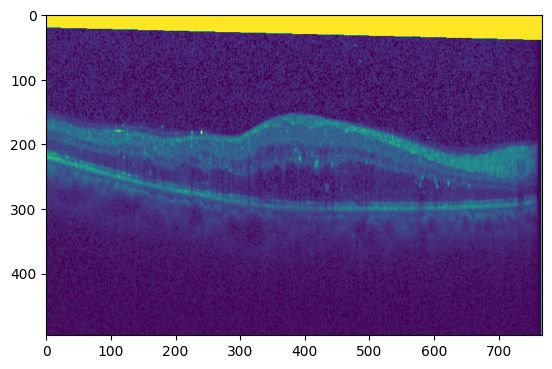

In [8]:
plt.imshow(img_array[22])

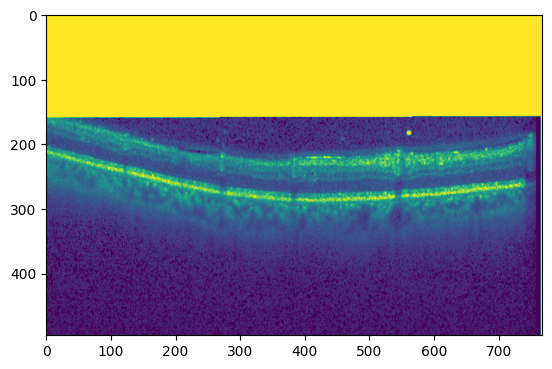

In [9]:
plt.imshow(img_array[1])

In [12]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float32])

def create_dataset(paths, key):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat[key]
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = np.nan_to_num(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))
        fluid_array = thresh(fluid_array)

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

In [13]:
x_train, y_train = create_dataset(subject_path[:9], 'manualFluid1')
x_val, y_val = create_dataset(subject_path[9:], 'manualFluid1')
train_mask = np.sum(y_train, axis=(1, 2, 3)) != 0
val_mask = np.sum(y_val, axis=(1, 2, 3)) != 0

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_val, y_val = x_val[val_mask], y_val[val_mask]

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [14]:
manual1_train_mask = train_mask

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((43, 1, 284, 284), (43, 1, 196, 196), (9, 1, 284, 284), (9, 1, 196, 196))

In [16]:
x_train, y_train = create_dataset(subject_path[:9], 'manualFluid2')
x_val, y_val = create_dataset(subject_path[9:], 'manualFluid2')
train_mask = np.sum(y_train, axis=(1, 2, 3)) != 0
val_mask = np.sum(y_val, axis=(1, 2, 3)) != 0

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_val, y_val = x_val[val_mask], y_val[val_mask]

100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


In [17]:
manual2_train_mask = train_mask

In [18]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((52, 1, 284, 284), (52, 1, 196, 196), (10, 1, 284, 284), (10, 1, 196, 196))

In [40]:
dataset = {
    'x_train': x_train,
    'y_train': y_train,
    'x_val': x_val, 
    'y_val': y_val
}

# np.savez(f'/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/automaticFluidDME', **dataset)

In [15]:
with_object, without_object = 0, 0
for i in y_train:
    if i.sum():
        with_object += 1
    else:
        without_object += 1

## Unet

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

/home/junhal11/miniconda3/envs/pgm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer
        

In [10]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1).contiguous()
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.view(-1, 2)
    labels = labels.view(-1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [24]:
batch_size = 9
epochs = 51
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [25]:
learning_rate = 0.01
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [26]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1).contiguous()
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.view(-1, 2)
    labels = y_val.view(-1)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [27]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

 98%|█████████▊| 50/51 [00:22<00:00,  2.10it/s]

Total loss in epoch 50 : 0.022695062682032585 and validation loss : 0.15708857774734497


100%|██████████| 51/51 [00:22<00:00,  2.23it/s]


In [14]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        print(image_arr.shape)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

In [15]:
from torchmetrics.classification import BinaryJaccardIndex

In [21]:
y_train.max()

1.0

In [28]:
y_pred = unet(torch.from_numpy(x_train).float().cuda())

print(y_pred)
iou_fn = BinaryJaccardIndex()
segment = y_pred.argmax(dim=1, keepdim=True).cpu()
iou_score = iou_fn(segment, torch.from_numpy(y_train))
print(iou_score)

tensor([[[[ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          [ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          [ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          ...,
          [ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          [ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          [ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237]],

         [[-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695],
          [-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695],
          [-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695],
          ...,
          [-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695],
          [-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695],
          [-8.0695, -8.0695, -8.0695,  ..., -8.0695, -8.0695, -8.0695]]],


        [[[ 5.8237,  5.8237,  5.8237,  ...,  5.8237,  5.8237,  5.8237],
          [ 5.8237,  5.8237,

In [23]:
y_pred = unet(torch.from_numpy(x_val).float().cuda())

print(y_pred)
iou_fn = BinaryJaccardIndex()
segment = y_pred.argmax(dim=1, keepdim=True).cpu()
iou_score = iou_fn(segment, torch.from_numpy(y_val))
print(iou_score)

tensor([[[[ 4.8166,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          [ 4.8271,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          [ 4.9309,  4.8168,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          ...,
          [ 4.8166,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          [ 4.8166,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          [ 4.8166,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166]],

         [[-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472],
          [-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472],
          [-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472],
          ...,
          [-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472],
          [-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472],
          [-7.3472, -7.3472, -7.3472,  ..., -7.3472, -7.3472, -7.3472]]],


        [[[ 4.8166,  4.8166,  4.8166,  ...,  4.8166,  4.8166,  4.8166],
          [ 4.8166,  4.8166,

(2, 196, 196)
(2, 196, 196)
(2, 196, 196)


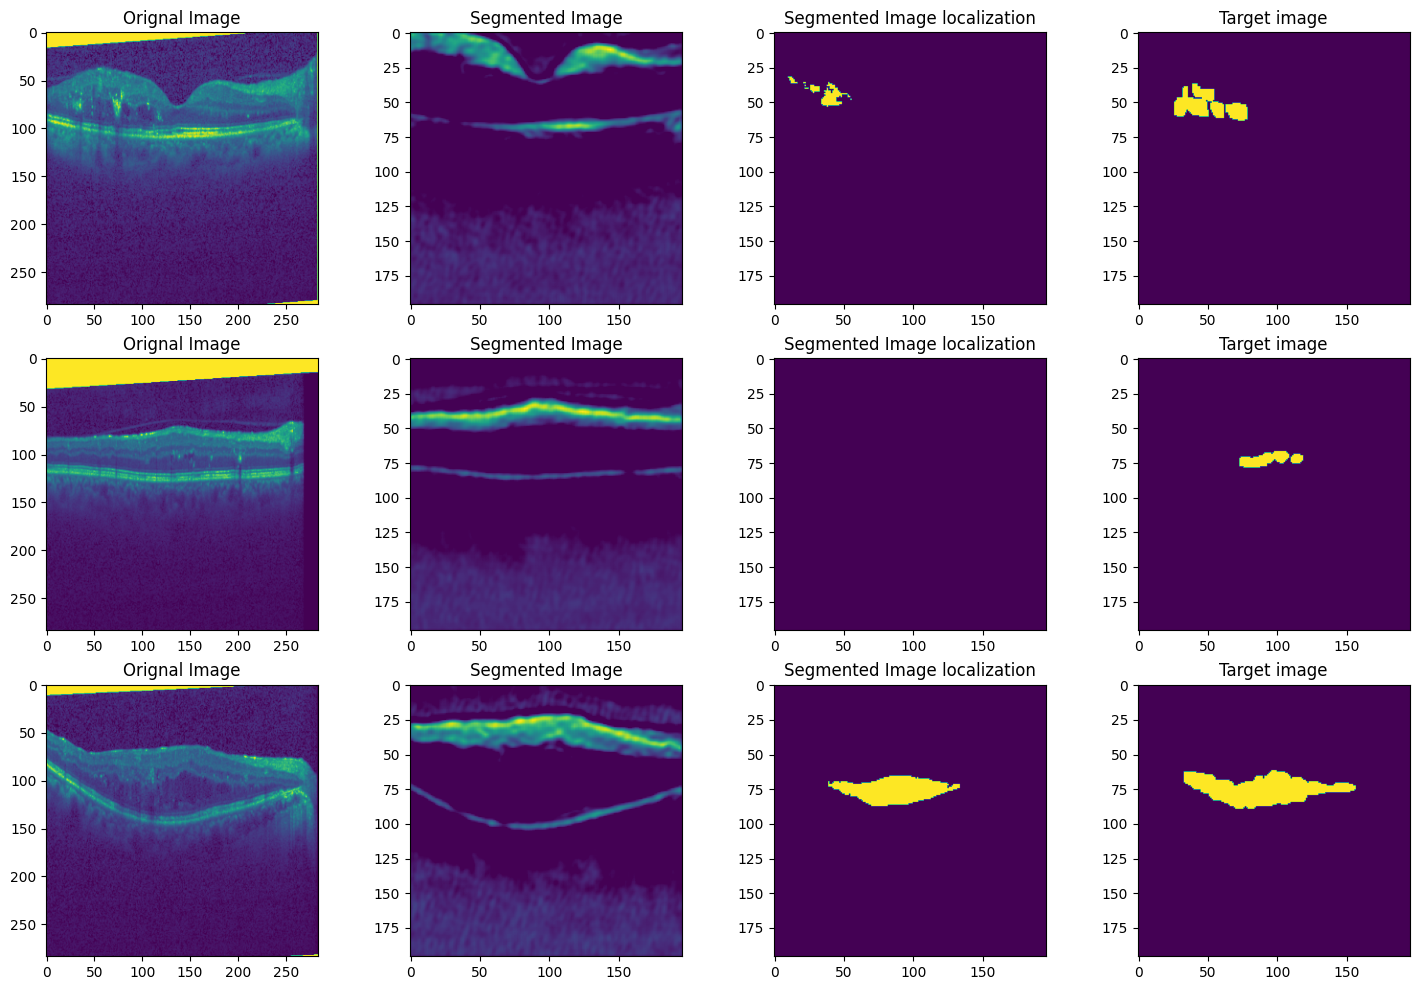

In [70]:
plot_examples(x_train, y_train)

(2, 196, 196)
(2, 196, 196)
(2, 196, 196)


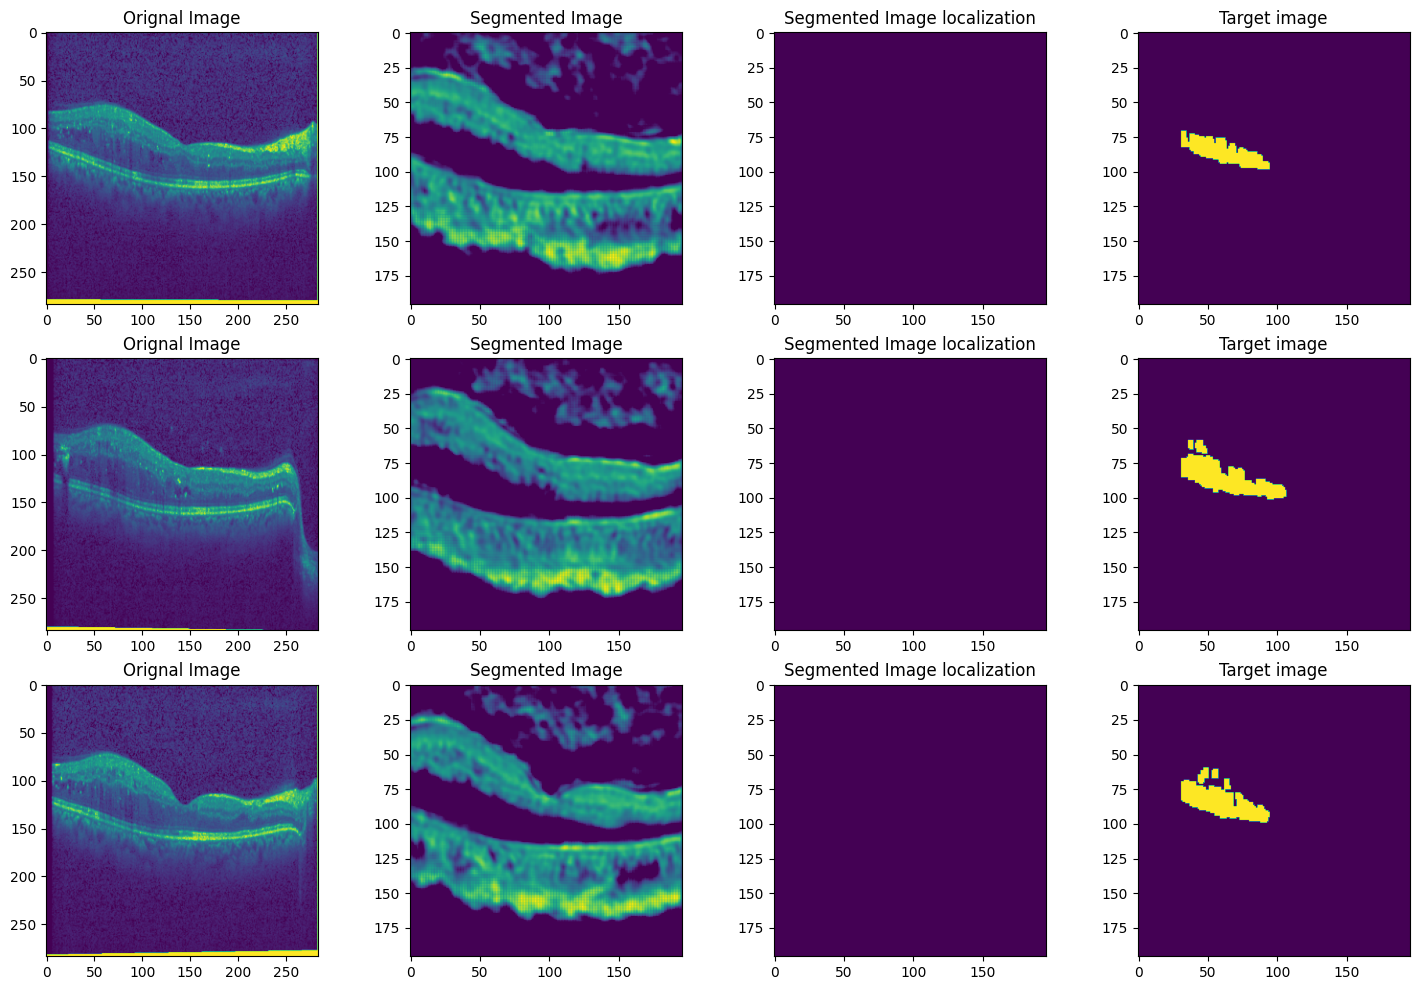

In [52]:
plot_examples(x_val, y_val)

In [19]:
torch.save(unet.state_dict(), 'unet.pt')

In [3]:
import sys
sys.path.append('/srv/disk00/junhal11/oct_understanding/')

from src.dataset import BoeChiuFluidSegDataset

/home/junhal11/miniconda3/envs/pgm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def plot_dataset_examples(dataset, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 3 * num_examples))
    m = len(dataset)
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        datax, datay = dataset[image_indx]
        ax[row_num][0].imshow(np.transpose(datax, (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(datay, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Target image")
    fig.tight_layout()
    plt.show()

In [6]:
dataset = BoeChiuFluidSegDataset('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/train_dataset.npz')

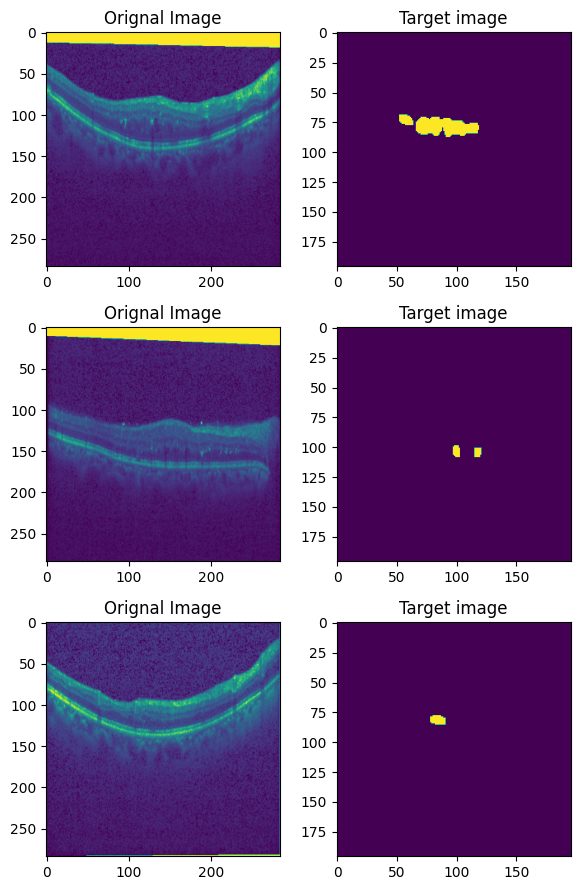

In [29]:
plot_dataset_examples(dataset)

In [81]:
manual_1 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_1.npz')
manual_2 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_2.npz')

train_x = np.concatenate([manual_1['x_train'], manual_2['x_train']], axis=0)
train_y = np.concatenate([manual_1['y_train'], manual_2['y_train']], axis=0)

test_x = np.concatenate([manual_1['x_val'], manual_2['x_val']], axis=0)
test_y = np.concatenate([manual_1['y_val'], manual_2['y_val']], axis=0)

np.savez('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/train_set', x=train_x, y=train_y)
np.savez('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/test_set', x=test_x, y=test_y)

In [3]:
manual_1 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_1.npz')
manual_2 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_2.npz')

X = np.concatenate([manual_1['x_train'], manual_1['x_val'], manual_2['x_train'], manual_2['x_val']], axis=0)
Y = np.concatenate([manual_1['y_train'], manual_1['y_val'], manual_2['y_train'], manual_2['y_val']], axis=0)

index = np.arange(len(X))
np.random.shuffle(index)
test_size = int(len(X) * 0.25)

train_x = X[index[:-test_size]]
train_y = Y[index[:-test_size]]

test_x = X[index[-test_size:]]
test_y = Y[index[-test_size:]]

np.savez('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/train_set_wo_xobject', x=train_x, y=train_y)
np.savez('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/test_set_wo_xobject', x=test_x, y=test_y)

In [82]:
manual_1['x_train'].shape

(43, 1, 284, 284)

In [83]:
manual_1['y_train'].shape

(43, 1, 196, 196)

In [86]:
manual_1['y_train'].sum()

34834.0

# Plot Example Image

In [19]:
manual_1 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_1.npz')
manual_2 = np.load('/srv/disk00/junhal11/oct_understanding/data/2015_boe_chiu/2015_BOE_Chiu/manual_2.npz')

In [21]:
arang_index = np.arange(len(manual1_train_mask))[np.logical_and(manual1_train_mask, manual2_train_mask)]

In [24]:
arang_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 14, 15, 16, 17, 19, 20, 21, 24,
       25, 26, 27, 28, 37, 48, 49, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       81, 82, 90, 91, 92, 93, 94, 95, 98])

In [4]:
manual_1['x_train'].shape

(43, 1, 284, 284)

In [73]:
def plot_sample_examples(datax, datay1, datay2):
    sample_num = len(datax)
    image_num = 3
    fig, ax = plt.subplots(nrows=sample_num, ncols=image_num, figsize=(3 * image_num, 3 * sample_num))
    
    if sample_num == 1:
        ax = [ax]
    for i in range(sample_num):
        ax[i][0].imshow(np.transpose(datax[i], (1, 2, 0))[:, :, 0], cmap='gray')
        ax[i][1].imshow(np.transpose(datay1[i], (1, 2, 0))[:, :, 0], cmap='gray')
        ax[i][2].imshow(np.transpose(datay2[i], (1, 2, 0))[:, :, 0], cmap='gray')
        
        # ax[i][0].set(f'Sample {i + 1}')
        if i == 0:
            ax[i][0].set_title("OCT Image")
            ax[i][1].set_title("Segmented Label 1")
            ax[i][2].set_title("Segmented Label 2")
        
        for a in ax[i]:
            a.set_axis_off()
            a.patch.set_edgecolor('black')  
            a.patch.set_linewidth('1')  
    return fig, ax

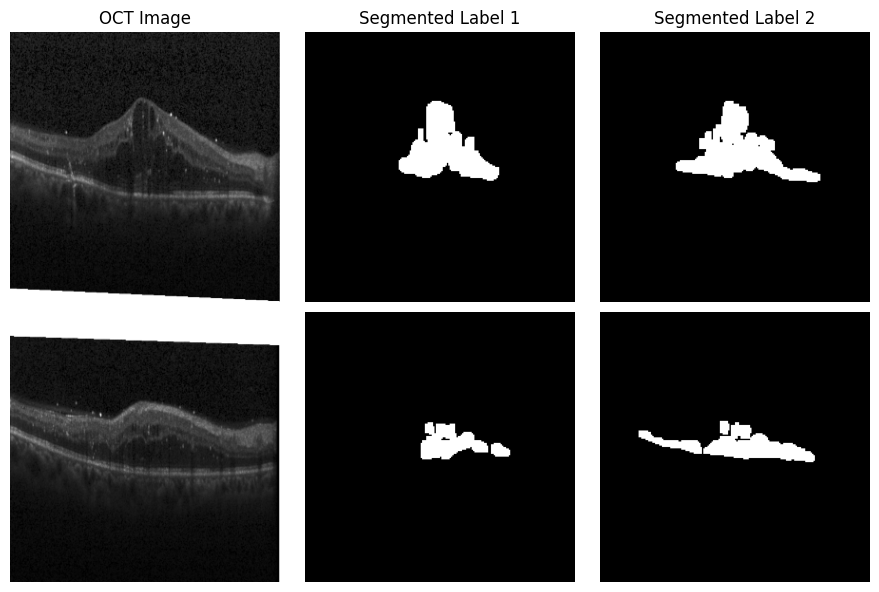

In [74]:
index_1, index_2 = 4, 2
fig, _ = plot_sample_examples(
    [manual_1['x_train'][index_1], manual_1['x_train'][index_2]],
    [manual_1['y_train'][index_1], manual_1['y_train'][index_2]],    
    [manual_2['y_train'][index_1], manual_2['y_train'][index_2]]
)
fig.tight_layout()
fig.savefig('uncertainty.pdf')